In [109]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from copy import deepcopy

In [110]:
import sys
sys.path.append("..")
sys.path.append("../filtering/")
sys.path.append("../probability/")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
from example_systems import generate_mackey_glass_system
tau = 20
dt = 1
mg_system_gt = generate_mackey_glass_system(dt,tau)

In [112]:
from helpers import vec

timesteps = np.arange(0.0, 800, step=mg_system_gt.delta_t)
T = len(timesteps)

states_gt = np.zeros((T, 21, 1))
controls = np.zeros((T, 1, 1))
measurements = np.zeros((T, 21, 1))

# initial position and velocity
states_gt[0] = np.zeros((21,1)) + 0.1

# cart acceleration schedule
t = np.min(np.argwhere(timesteps > 1.0))
controls = timesteps

for t in tqdm(range(1, T)):
    if t < (tau):
        x = np.zeros((21,1)) + 0.1
        for i in range(0,t):
            x[20-i,0] = states_gt[i,0,0]
        x = x.reshape((21,))
    else:
        x = np.zeros((21,1))
        x[0,0] = states_gt[t-1,0,0]
        x[1,0] = states_gt[t-2,0,0]
        x[2,0] = states_gt[t-3,0,0]
        x[3,0] = states_gt[t-4,0,0]
        x[4,0] = states_gt[t-5,0,0]
        x[5,0] = states_gt[t-6,0,0]
        x[6,0] = states_gt[t-7,0,0]
        x[7,0] = states_gt[t-8,0,0]
        x[8,0] = states_gt[t-9,0,0]
        x[9,0] = states_gt[t-10,0,0]

        x[10,0] = states_gt[t-11,0,0]
        x[11,0] = states_gt[t-12,0,0]
        x[12,0] = states_gt[t-13,0,0]
        x[13,0] = states_gt[t-14,0,0]
        x[14,0] = states_gt[t-15,0,0]
        x[15,0] = states_gt[t-16,0,0]
        x[16,0] = states_gt[t-17,0,0]
        x[17,0] = states_gt[t-18,0,0]
        x[18,0] = states_gt[t-19,0,0]
        x[19,0] = states_gt[t-20,0,0]

        x[20,0] = states_gt[t-21,0,0]
        x = x.reshape((21,))

    #print(x)

    #x = x.reshape((6,))
    #print(x)
    u = controls[t]

    x_next = mg_system_gt.query_dynamics_model(x, u)
    #print(states_gt[t].shape)
    states_gt[t] = x_next

    z = mg_system_gt.query_measurement_model(x_next)
    measurements[t] = z


100%|██████████| 799/799 [00:00<00:00, 1654.82it/s]


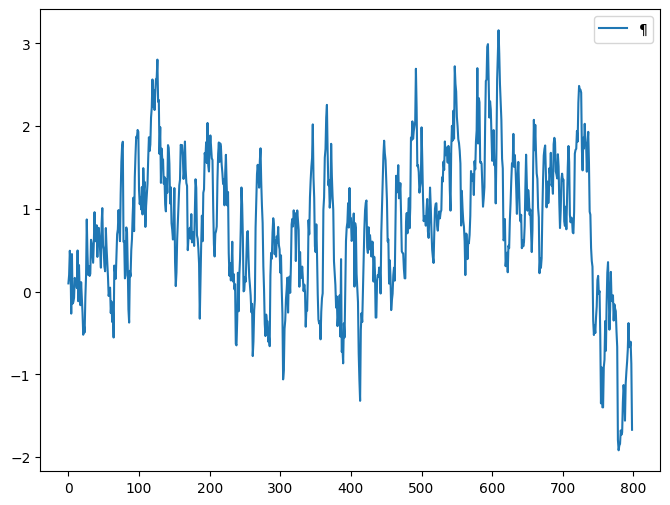

In [113]:
t_max = np.max(np.argwhere(~np.isnan(states_gt[:,0,0])))

if t_max < T-1:
    print("WARNING: System diverges at around t =", t_max)
    t_max -= 10

P_gt = states_gt[:t_max,0,0]

fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(timesteps[:t_max], cart_gt, label="cart")
# ax.plot(timesteps[:t_max], cart_vel_gt, label="cart_vel")
ax.plot(timesteps[:t_max], P_gt, label=r"$\P$")
ax.legend(ncol=2)

In [114]:
# Test all filters on same system model approximation
subsample = 1    # filters run at a fraction of sampling rate of the simulation
timesteps_sub = timesteps[::subsample]
states_gt_sub = states_gt[::subsample]
measurements_sub = measurements[::subsample]
controls_sub = controls[::subsample]
T_sub = len(timesteps_sub)

mg_system_approx = generate_mackey_glass_system(dt=mg_system_gt.delta_t * subsample)

In [115]:
# Test all filters with the same initial belief
#initial_covariance = np.diag([0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1,
#                              0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2,
#                              0.3, 0.1, 0.2, 0.3, 0.1, 0.2, 0.3])*0.01
initial_covariance = np.diag([1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3,
                              1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3,
                              1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3,])
initial_mean = np.random.multivariate_normal(states_gt[0,:,0], initial_covariance).reshape(-1, 1)
print(initial_mean)
print(initial_covariance)
initial_state_estimate = (initial_mean, initial_covariance)
#initial_state_estimate

[[0.03359614]
 [0.11645374]
 [0.09950718]
 [0.14603053]
 [0.15822646]
 [0.09234582]
 [0.14878919]
 [0.03428117]
 [0.11102588]
 [0.07683719]
 [0.09981558]
 [0.15663263]
 [0.07465694]
 [0.11974813]
 [0.08049776]
 [0.11259698]
 [0.09675535]
 [0.15694019]
 [0.10904837]
 [0.12919322]
 [0.12753864]]
[[0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0. 

In [116]:
def plot_filter_results(mean, filter_name): # Needs to be updated for this system
    fig, (ax1) = plt.subplots()
    fig.suptitle(f"Filtering Results: {filter_name}")

    ax1.set_xlabel("time")
    ax1.plot(timesteps_sub, states_gt_sub[:,0,0])
    ax1.plot(timesteps_sub, mean)
    #ax1.set_xlim([0, 800])
    #ax1.set_ylim([0, 2.5])

100%|██████████| 799/799 [00:02<00:00, 279.93it/s]


Range Complete!


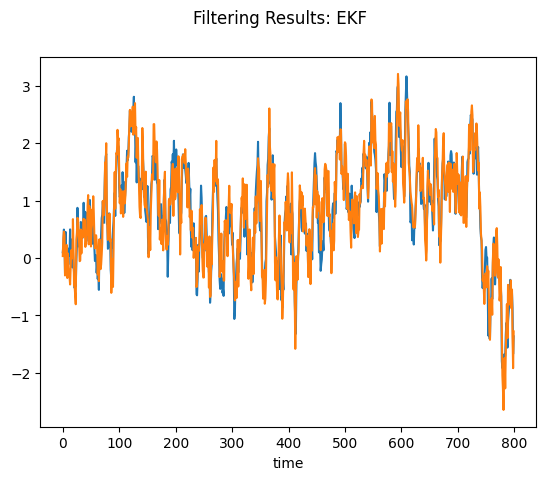

In [117]:
# Run the EKF

from filters import ExtendedKalmanFilter

mg_EKF = ExtendedKalmanFilter(mg_system_approx)

# initial state belief
mg_EKF.initialize(initial_mean,initial_covariance)

means_EKF = np.zeros((T_sub, 21, 1)) + 0.1
covariances_EKF = np.zeros((T_sub, 21, 21))

means_EKF[0] = mg_EKF.mean
covariances_EKF[0] = mg_EKF.covariance

for t in tqdm(range(1, T_sub)):
    u = controls_sub[t]
    z = measurements_sub[t]
    z.reshape((21,1))

    #print('Timestep: ' + str(int(t)))
    mg_EKF.predict_step(u)
    mg_EKF.update_step(z)
    
    means_EKF[t] = mg_EKF.mean
    covariances_EKF[t] = mg_EKF.covariance

print("Range Complete!")

# Plot results
plot_filter_results(means_EKF[:,0,0], "EKF")

100%|██████████| 799/799 [00:08<00:00, 98.71it/s] 


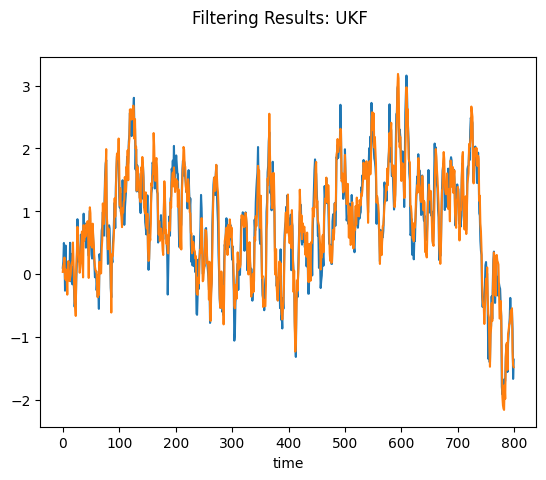

In [118]:
# Run the UKF

from filters import UnscentedKalmanFilter
mg_UKF = UnscentedKalmanFilter(mg_system_approx)

# initial state belief
mg_UKF.initialize(initial_mean,initial_covariance)

means_UKF = np.zeros((T_sub, 21, 1))
covariances_UKF = np.zeros((T_sub, 21, 21))

means_UKF[0] = mg_UKF.mean
covariances_UKF[0] = mg_UKF.covariance


for t in tqdm(range(1, T_sub)):
    u = controls_sub[t]
    z = measurements_sub[t]

    mg_UKF.predict_step(u)
    mg_UKF.update_step(z)

    means_UKF[t] = mg_UKF.mean
    covariances_UKF[t] = mg_UKF.covariance


# Plot results
plot_filter_results(means_UKF[:,0,0], "UKF")

100%|██████████| 799/799 [00:15<00:00, 50.94it/s]


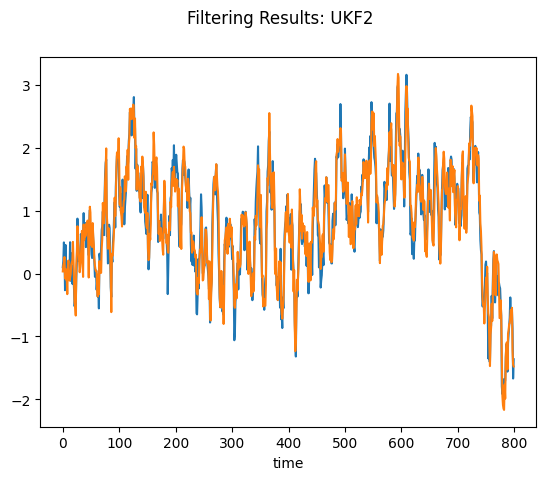

In [119]:
# Run the UKF Variant

from sigma_points import MultiShellSigmaPointSelector

mg_UKF2 = UnscentedKalmanFilter(
    mg_system_approx,
    sigma_point_selector=MultiShellSigmaPointSelector([0.1, 0.5])
)

# initial state belief
mg_UKF2.initialize(*initial_state_estimate)

means_UKF2 = np.zeros((T_sub, 21, 1))
covariances_UKF2 = np.zeros((T_sub, 21, 21))

means_UKF2[0] = mg_UKF2.mean
covariances_UKF2[0] = mg_UKF2.covariance


for t in tqdm(range(1, T_sub)):
    u = controls_sub[t]
    z = measurements_sub[t]

    mg_UKF2.predict_step(u)
    mg_UKF2.update_step(z)

    means_UKF2[t] = mg_UKF2.mean
    covariances_UKF2[t] = mg_UKF2.covariance


# Plot results
plot_filter_results(means_UKF2[:,0,0], "UKF2")

In [120]:
# Error Analysis

errors_EKF = means_EKF - states_gt_sub
errors_UKF = means_UKF - states_gt_sub
errors_UKF2 = means_UKF2 - states_gt_sub

print("EKF Error: ", np.mean(np.linalg.norm(errors_EKF, axis=1)))
print("UKF Error: ", np.mean(np.linalg.norm(errors_UKF, axis=1)))
print("UKF2 Error:", np.mean(np.linalg.norm(errors_UKF2, axis=1)))

EKF Error:  1.7214811110850925
UKF Error:  1.2986642609163672
UKF2 Error: 1.2986632228311599


: 